# Relevance Classification Task

By James Khumalo and Taruk Buisson

## Overview
<div style='text-align: justify;'>In this deep learning project, we embarked on a comprehensive exploration of a combination of a machine learning and neural network models to tackle our classification tasks. Starting with standard ML baselines like Multinomial Naive Bayes, we transitioned to more complex architectures such as feed-forward neural networks, recurrent neural networks (RNNs) like GRU and LSTM, and deep neural networks (DNNs). Throughout our experimentation, we observed the interplay between model complexity, performance, and the importance of hyperparameter tuning. Our key takeaways include the need for iterative experimentation, careful monitoring of model performance, and the understanding that higher complexity does not always translate to better results. Our recommendation include leveraging simpler models when appropriate, regularizing complex models to prevent overfitting, and maintaining a balance between model complexity and computational resources.</div>


## Method
<div style='text-align: justify;'>Through an extensive exploration of the dataset, several key findings emerged that will shape the modeling approach. Firstly, the dataset consists of both labeled training data and unlabeled test data, necessitating the development of a supervised learning model capable of predicting the relevance of newspaper articles. Secondly, the dataset contains a mix of categorical and textual features, with the 'description' and 'narrative' columns providing rich textual information that is crucial for assessing relevance. Consequently, techniques for handling and extracting features from text data will be essential. Moreover, the presence of redundant columns like 'topic_id' and 'byline' highlights the need for careful feature selection or dimensionality reduction methods. These insights collectively inform the data preprocessing steps, feature engineering techniques, and the choice of appropriate modeling algorithms to effectively capture the underlying patterns and accurately predict document relevance.</div>

#### Import Packages and Dataset

In [60]:
# Import Necessary Libraries

# Data Manulipations
import pandas as pd
import numpy as np
import os

# Data Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Text preprocessing
import spacy
from sklearn.feature_extraction.text import TfidfVectorizer

# Machine Learning
import tensorflow as tf
from sklearn.model_selection import cross_val_score
from sklearn.naive_bayes import MultinomialNB
from tensorflow import keras
from tensorflow.keras import layers
from keras.initializers import HeNormal
from sklearn.metrics import accuracy_score, classification_report
from tensorflow.keras.optimizers import RMSprop
import torch
from keras.models import Sequential
from keras.layers import Flatten, Dense, LSTM

# Suppress All Warnings
import warnings
warnings.filterwarnings("ignore")

In [62]:
# Load the train.csv file.
X_train = pd.read_parquet(r"C:\Users\james\Downloads\cs985-987-relevance-prediction-2024\relevance_train.parquet")
X_test = pd.read_parquet(r"C:\Users\james\Downloads\cs985-987-relevance-prediction-2024\relevance_test.parquet")

#### User Defintion Function

In [3]:
# Function for test pre-processing
def get_document_vector(text):
    if text is None or not text.strip():  # check if text is None or empty after stripping whitespace
        return np.zeros(nlp.vocab.vectors_length)  # return zero vector if no text

    doc = nlp(text)
    return doc.vector  # obtain the document vector directly

In [4]:
# Function for predicted judgement values for Kaggle
def output(y_pred, modelname):
    # create the file name using the model name
    file_name = f'results_{modelname}.csv'
    
    # creating the uploadable CSV file to upload to Kaggle
    # matching the 'doc-id' column values with the predictions into a pandas dataframe to save as CSV
    results_df = pd.DataFrame({'id': X_test_docids, 'judgement': y_pred})

    results_df.to_csv(file_name, index=False)

#### Data Inspection

In [5]:
# Check the columns and dimensions of the dataset.
print("Relevance Train Columns:\n", X_train.columns, "\n")
print("Relevance Train Shape:\n", X_train.shape, "\n")

print("\nRelevance Test Columns:\n", X_test.columns, "\n")
print("Relevance Test Shape:\n", X_test.shape, "\n")

Relevance Train Columns:
 Index(['doc_id', 'judgement', 'author', 'body', 'byline', 'title', 'topic_id',
       'description', 'narrative', 'topic_title'],
      dtype='object') 

Relevance Train Shape:
 (19758, 10) 


Relevance Test Columns:
 Index(['doc_id', 'author', 'body', 'byline', 'title', 'topic_id',
       'description', 'narrative', 'topic_title'],
      dtype='object') 

Relevance Test Shape:
 (4884, 9) 



In [6]:
# Display the first few rows of the traing dataset.
print('Training Data:\n', X_train.head(), '\n')


Training Data:
                                  doc_id  judgement           author  \
0      004c6120d0aa69da29cc045da0562168          0   Terrence McCoy   
1      005a1f0c2064487a7f15443b2a5f349a          0    Brian McNoldy   
2  00722094-2935-11e2-b4e0-346287b7e56c          0  Editorial Board   
3  007d2856-7cc4-11e4-84d4-7c896b90abdc          0   Adam Bernstein   
4  009aafb6-0283-11e6-8bb1-f124a43f84dc          0             None   

                                                body              byline  \
0  <p>More than 60 years ago, a fair-skinned Iris...   By Terrence McCoy   
1  <p>Hurricane Fred, which formed over the weeke...    By Brian McNoldy   
2  <p>EIGHT YEARS AGO this month, an inspiring mo...  By Editorial Board   
3  <p>Mary Burke Washington, an economist who was...   By Adam Bernstein   
4  <p>When Treasury Secretary Jack Lew <a href="h...                None   

                                               title  topic_id  \
0  Report on Irish baby homes docu

In [7]:
# Check the values in the target variable, 'judgement'
print('Judgement Column Values:\n', X_train['judgement'].unique())

Judgement Column Values:
 [0 1]


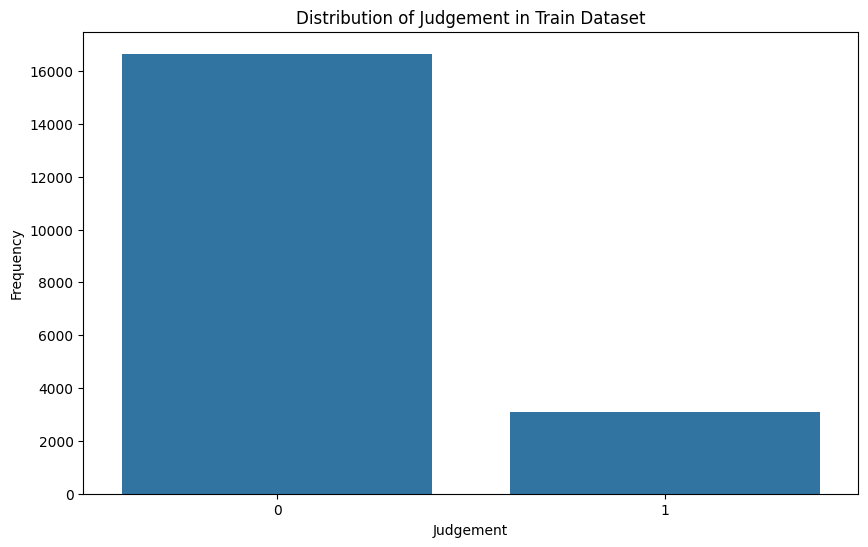

In [64]:
# Plotting the distribution of 'judgement' in the train dataset
plt.figure(figsize=(10, 6))
sns.countplot(x='judgement', data=X_train)
plt.title('Distribution of Judgement in Train Dataset')
plt.xlabel('Judgement')
plt.ylabel('Frequency')
plt.show()

In [8]:
# Check features in the training dataset.
print('Description Column:\n',X_train['description'][1])
print('\nNarrative Column:\n',X_train['narrative'][1])

Description Column:
 Pertinent documents will reflect the fact that women continue to be poorly represented in parliaments across the world, and the gap in political power between the sexes is very wide, particularly in the Third World.

Narrative Column:
 Pertinent documents relating to this issue will discuss the lack of representation by women, the countries that mandate the inclusion of a certain percentage of women in their legislatures,
decreases if any in female representation in legislatures, and those countries in which there is no representation of women.


In [9]:
# Check features in the training dataset.
print('Author:\n',X_train['author'].head())
print('\nByline:\n',X_train['byline'].head())

Author:
 0     Terrence McCoy
1      Brian McNoldy
2    Editorial Board
3     Adam Bernstein
4               None
Name: author, dtype: object

Byline:
 0     By Terrence McCoy
1      By Brian McNoldy
2    By Editorial Board
3     By Adam Bernstein
4                  None
Name: byline, dtype: object


In [10]:
# Check the values in the 'author'
print(X_train['author'].value_counts())

author
Editorial Board                                               290
Christopher Ingraham                                          176
Rachel Feltman                                                174
Hayley Tsukayama                                              172
Jennifer Rubin                                                166
                                                             ... 
Joe Kunches                                                     1
Rick Noack; Luz Lazo; Devlin Barrett                            1
Gabriel Florit, Kim Soffen, Aaron Steckelberg and Tim Meko      1
James Bessen                                                    1
John Lippert; Mario Parker                                      1
Name: count, Length: 3365, dtype: int64


In [11]:
# Check features in the training dataset.
print('Topic ID:\n',X_train['topic_id'].head())
print('\nTopic Title:\n',X_train['topic_title'].head())

Topic ID:
 0    321
1    321
2    321
3    321
4    321
Name: topic_id, dtype: int64

Topic Title:
 0    Women in Parliaments
1    Women in Parliaments
2    Women in Parliaments
3    Women in Parliaments
4    Women in Parliaments
Name: topic_title, dtype: object


#### Text Preprocessing
<div style='text-align: justify;'>Pre-processing the data involves removing redundant columns like 'topic_id', 'byline', and 'doc_id', ensuring that the textual content is tokenized, lemmatized, and stripped of stopwords and punctuation. The objective is to convert the text into numeric vectors for machine learning. The chosen approach involves using a pre-trained English language model, specifically SpaCy's 'en_core_web_md,' to transform the text into vectors of 300 dimensions. This model captures semantic information about words and supports Named Entity Recognition, enhancing its ability to capture meaning and relevance. The lower dimensionality of SpaCy vectors compared to tf-idf vectors, along with the semantic features, makes it a preferable choice for this task.</div>
&nbsp;

<div style='text-align: justify;'>Regarding the test/train/validation strategy, each feature in the dataset remains separate, allowing the models to learn the relationship between query-related and document-related columns. The data is transformed into 3D tensors and scaled between -1 and 1 to ensure compatibility with the neural network models. The consistency in data preprocessing and splitting ensures that the models are trained, validated, and tested consistently across different architectures, enabling fair comparisons of their performance relative to baseline models.</div>

In [12]:
# Drop unnecessary columns in the datasets.
X_test_docids = X_test['doc_id'].copy()
X_train = X_train.drop(columns=['topic_id', 'byline', 'doc_id'])
X_test = X_test.drop(columns=['topic_id', 'byline', 'doc_id'])

In [13]:
# Re-check the columns and dimensions of the dataset.
print("Relevance Train Columns:\n", X_train.columns, "\n")
print("Relevance Train Shape:\n", X_train.shape, "\n")

print("\nRelevance Test Columns:\n", X_test.columns, "\n")
print("Relevance Test Shape:\n", X_test.shape, "\n")

Relevance Train Columns:
 Index(['judgement', 'author', 'body', 'title', 'description', 'narrative',
       'topic_title'],
      dtype='object') 

Relevance Train Shape:
 (19758, 7) 


Relevance Test Columns:
 Index(['author', 'body', 'title', 'description', 'narrative', 'topic_title'], dtype='object') 

Relevance Test Shape:
 (4884, 6) 



In [14]:
# Split training data into a 'training' and 'validation' set.
# First set 'judgement' as teh target feature
y_train = X_train['judgement']
X_train.drop(columns=['judgement'], inplace=True)

X_train_partial = X_train[3000:]
X_train_valid = X_train[:3000]

y_train_partial = y_train[3000:]
y_train_valid = y_train[:3000]


In [15]:
# Load English language model
try:
    nlp = spacy.load('en_core_web_md')
except OSError:
    from spacy.cli import download
    download('en_core_web_md')
    nlp = spacy.load('en_core_web_md')

In [16]:
# Define columns to process
columns_to_process = ['description', 'narrative', 'author', 'topic_title', 'body', 'title']

# Loop for processing the text data
X_train_partial_embedded = pd.DataFrame()
X_train_valid_embedded = pd.DataFrame()
X_test_embedded = pd.DataFrame()

for column in columns_to_process:
    X_train_partial_embedded[column] = X_train_partial[column].apply(get_document_vector)
    X_train_valid_embedded[column] = X_train_valid[column].apply(get_document_vector)
    X_test_embedded[column] = X_test[column].apply(get_document_vector)

print("Shape of X_train_partial_embedded:", X_train_partial_embedded.shape)

Shape of X_train_partial_embedded: (16758, 6)


In [17]:
# Define the dataframes and tensors
dataframes = [X_train_partial_embedded, X_train_valid_embedded, X_test_embedded]
tensors = [None, None, None]

# Loop over dataframes
for i, df in enumerate(dataframes):
    stacked_arrays = []
    # Loop over columns
    for column in columns_to_process:
        stacked_arrays.append(np.stack(df[column]))
    # Stack arrays along the second axis
    tensors[i] = np.stack(stacked_arrays)

# Transpose tensors
for i in range(3):
    tensors[i] = np.transpose(tensors[i], (1, 0, 2))

# Assign tensors to variables
X_train_partial_tensor, X_train_valid_tensor, X_test_tensor = tensors

print("Shape of X_train_partial_tensor:", X_train_partial_tensor.shape)


Shape of X_train_partial_tensor: (16758, 6, 300)


In [18]:
# Calculate the maximum and minimum values
max_val = np.max(X_train_partial_tensor)
print("Maximum value:", max_val)

min_val = np.min(X_train_partial_tensor)
print("Minimum value:", min_val)

Maximum value: 18.527999877929688
Minimum value: -20.832000732421875


#### Text Preprocessing for Base Machine Learning Model

In [19]:
# List of tensors and scaled tensors
tensors = [X_train_partial_tensor, X_train_valid_tensor, X_test_tensor]
scaled_tensors = []

# Loop over each tensor
for tensor in tensors:
    # Calculate max, min, and range values
    max_value = tf.reduce_max(tensor)
    min_value = tf.reduce_min(tensor)
    range_value = max_value - min_value
    
    # Scale the tensor
    scaled_tensor = (tensor - min_value) / range_value * 2 - 1
    
    # Append scaled tensor to the list
    scaled_tensors.append(scaled_tensor)

# Unpack scaled tensors
X_train_partial_scaled, X_train_valid_scaled, X_test_scaled = scaled_tensors

In [20]:
# Initialize TF-IDF vectorizer with max features
tfidf_vectorizer = TfidfVectorizer(max_features=30000)

# Concatenate text columns for training data, handling NaNs
train_text_data = (X_train_partial['body'].fillna('') + ' ' + 
                   X_train_partial['title'].fillna('') + ' ' + 
                   X_train_partial['description'].fillna('') + ' ' + 
                   X_train_partial['narrative'].fillna('') + ' ' + 
                   X_train_partial['topic_title'].fillna('') + ' ' + 
                   X_train_partial['author'].fillna(''))

# Fit TF-IDF vectorizer on training data
X_train_partial_tfidf = tfidf_vectorizer.fit_transform(train_text_data)

# Transform validation data with fitted vectorizer
X_train_valid_tfidf = tfidf_vectorizer.transform((X_train_valid['body'].fillna('') + ' ' + 
                                                  X_train_valid['title'].fillna('') + ' ' + 
                                                  X_train_valid['description'].fillna('') + ' ' + 
                                                  X_train_valid['narrative'].fillna('') + ' ' + 
                                                  X_train_valid['topic_title'].fillna('') + ' ' + 
                                                  X_train_valid['author'].fillna('')))

# Transform test data with fitted vectorizer
X_test_tfidf = tfidf_vectorizer.transform((X_test['body'].fillna('') + ' ' + 
                                           X_test['title'].fillna('') + ' ' + 
                                           X_test['description'].fillna('') + ' ' + 
                                           X_test['narrative'].fillna('') + ' ' + 
                                           X_test['topic_title'].fillna('') + ' ' + 
                                           X_test['author'].fillna('')))


## Models

### Multinomial Naive Bayes - Baseline Machine Learning Model
<div style='text-align: justify;'>In this project, we explored various models to tackle classification tasks, starting with a standard machine learning baseline model which is a Multinomial Naive Bayes model. The Multinomial Naive Bayes model yielded an 86% accuracy on the validation set, but its performance was limited due to the majority of relevance values being zero.</div>

In [21]:
# Instantiate the Multinomial Naive Bayes model
nb_model = MultinomialNB()

# Train the model on the TF-IDF transformed training data
nb_model.fit(X_train_partial_tfidf, y_train_partial)

# Predict classes on the validation set
y_pred_valid = nb_model.predict(X_train_valid_tfidf)

# Display the classification report
print("Classification Report:")
print(classification_report(y_train_valid, y_pred_valid))

# Calculate and store the accuracy score
accuracy_nb = accuracy_score(y_train_valid, y_pred_valid)

Classification Report:
              precision    recall  f1-score   support

           0       0.86      1.00      0.92      2526
           1       0.93      0.11      0.19       474

    accuracy                           0.86      3000
   macro avg       0.89      0.55      0.56      3000
weighted avg       0.87      0.86      0.81      3000



### 3-Layer Neural Network - Baseline Nearal Network Model
<div style='text-align: justify;'>Transitioning to neural networks, we experimented with a 3-layer feed-forward neural network as our baseline. Despite the model's increasing performance on the training set, it exhibited signs of overfitting on the validation set after four epochs. Exploring different configurations, we observed that models with fewer neurons tended to show less overfitting but struggled to capture complexity beyond the baseline accuracy of 84%. Interestingly, the relationship between accuracy and loss varied, with accuracy remaining stable while loss increased, highlighting the importance of understanding how metrics are computed.</div>

In [22]:
# Define the neural network architecture
model_nn = Sequential([
    layers.Flatten(input_shape=(6, 300)), 
    layers.Dense(250, activation="relu", kernel_initializer='glorot_uniform'),
    layers.Dense(1, activation="sigmoid", kernel_initializer='glorot_uniform'),
])

# Define the optimizer for the model
optimizer = RMSprop(learning_rate=0.001)


# Compile the model
model_nn.compile(optimizer=optimizer,
                  loss='binary_crossentropy',
                  metrics=['accuracy'])

# Train the model using training data and validate using validation data
history = model_nn.fit(X_train_partial_scaled, y_train_partial, epochs=25, batch_size=32, validation_data=(X_train_valid_scaled, y_train_valid))

# Evaluate the model on validation data to get loss and accuracy
loss_nn250, accuracy_nn250 = model_nn.evaluate(X_train_valid_scaled, y_train_valid)

# Extract loss and accuracy from history
loss_history = history.history['loss']
accuracy_history = history.history['accuracy']

# Calculate mean loss and accuracy
mean_loss_nn250 = np.mean(loss_history)
mean_accuracy_nn250 = np.mean(accuracy_history)

# Calculate standard deviation of loss and accuracy
std_loss_nn250 = np.std(loss_history)
std_accuracy_nn250 = np.std(accuracy_history)

# Print mean loss, mean accuracy, standard deviation of loss, and standard deviation of accuracy
print("Mean Loss:", mean_loss_nn250)
print("Mean Accuracy:", mean_accuracy_nn250)
print("Standard Deviation of Loss:", std_loss_nn250)
print("Standard Deviation of Accuracy:", std_accuracy_nn250)

Epoch 1/25
524/524 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.8446 - loss: 0.4217 - val_accuracy: 0.2560 - val_loss: 0.7545
Epoch 2/25
524/524 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8446 - loss: 0.3921 - val_accuracy: 0.1997 - val_loss: 0.8087
Epoch 3/25
524/524 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8458 - loss: 0.3844 - val_accuracy: 0.2593 - val_loss: 0.8549
Epoch 4/25
524/524 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8503 - loss: 0.3710 - val_accuracy: 0.3183 - val_loss: 0.8554
Epoch 5/25
524/524 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8530 - loss: 0.3658 - val_accuracy: 0.2997 - val_loss: 0.9508
Epoch 6/25
524/524 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8538 - loss: 0.3529 - val_accuracy: 0.4480 - val_loss: 0.8832
Epoch 7/25
524/524 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8582 - loss: 0.3513 - val_accuracy: 0.5423 - val_loss: 0.8385
Epoch 8/25
524/524 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8610 - loss: 0.3386 - val_accuracy: 0.

Running with 50 neurons
Epoch 1/25
524/524 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.8368 - loss: 0.4181 - val_accuracy: 0.3350 - val_loss: 0.7126
Epoch 2/25
524/524 ━━━━━━━━━━━━━━━━━━━━ 0s 898us/step - accuracy: 0.8427 - loss: 0.3919 - val_accuracy: 0.3367 - val_loss: 0.7157
Epoch 3/25
524/524 ━━━━━━━━━━━━━━━━━━━━ 0s 916us/step - accuracy: 0.8442 - loss: 0.3836 - val_accuracy: 0.3693 - val_loss: 0.7034
Epoch 4/25
524/524 ━━━━━━━━━━━━━━━━━━━━ 0s 877us/step - accuracy: 0.8462 - loss: 0.3727 - val_accuracy: 0.4017 - val_loss: 0.6996
Epoch 5/25
524/524 ━━━━━━━━━━━━━━━━━━━━ 0s 877us/step - accuracy: 0.8440 - loss: 0.3716 - val_accuracy: 0.4827 - val_loss: 0.6806
Epoch 6/25
524/524 ━━━━━━━━━━━━━━━━━━━━ 0s 870us/step - accuracy: 0.8438 - loss: 0.3767 - val_accuracy: 0.4117 - val_loss: 0.6940
Epoch 7/25
524/524 ━━━━━━━━━━━━━━━━━━━━ 0s 876us/step - accuracy: 0.8511 - loss: 0.3574 - val_accuracy: 0.5453 - val_loss: 0.6626
Epoch 8/25
524/524 ━━━━━━━━━━━━━━━━━━━━ 0s 875us/step - accuracy: 0.

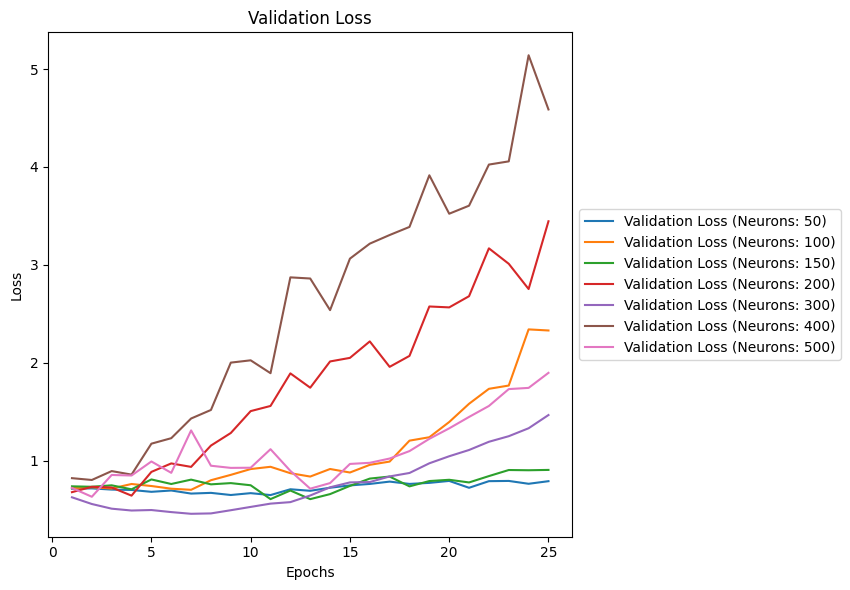

In [23]:
# List of neuron values to iterate over
neuron_values = [50, 100, 150, 200, 300, 400, 500]

# Initialize lists for performance metrics
train_accuracies_nn = []  # Training accuracies
val_accuracies_nn = []    # Validation accuracies
train_losses_nn = []      # Training losses
val_losses_nn = []        # Validation losses

# Iterate over different neuron values
for neurons in neuron_values:
    # Print current neuron value
    print(f"Running with {neurons} neurons")

    # Define neural network 
    model_nn = Sequential([
        layers.Flatten(input_shape=(6, 300)),  # Flatten layer
        layers.Dense(neurons, activation="relu", kernel_initializer='glorot_uniform'),  # Dense layer with ReLU activation
        layers.Dense(1, activation="sigmoid", kernel_initializer='glorot_uniform'),  # Output layer with sigmoid activation
    ])

    # Define optimizer
    optimizer = RMSprop(learning_rate=0.001)

    # Compile the model
    model_nn.compile(optimizer=optimizer,
                      loss='binary_crossentropy',
                      metrics=['accuracy'])

    # Train the model
    history = model_nn.fit(X_train_partial_scaled, y_train_partial, epochs=25, batch_size=32,
                           validation_data=(X_train_valid_scaled, y_train_valid), verbose=1)

    # Extract and append training and validation loss
    train_losses_nn.append(history.history['loss'])
    val_losses_nn.append(history.history['val_loss'])

    # Evaluate model performance on training and validation sets
    train_loss, train_accuracy = model_nn.evaluate(X_train_partial_scaled, y_train_partial, verbose=0)
    val_loss, val_accuracy = model_nn.evaluate(X_train_valid_scaled, y_train_valid, verbose=0)

    # Append performance metrics to lists
    train_accuracies_nn.append(train_accuracy)
    val_accuracies_nn.append(val_accuracy)

# Plot validation loss
plt.figure(figsize=(14, 6))
plt.subplot(1, 2, 2)
for i in range(len(neuron_values)):
    epochs = range(1, len(val_losses_nn[i]) + 1)  # Adjust epochs to match the length of validation loss data
    plt.plot(epochs, val_losses_nn[i], label=f'Validation Loss (Neurons: {neuron_values[i]})')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Validation Loss')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))  
plt.tight_layout()  

In [81]:
# # Define the neural network
model_nn = Sequential([
    layers.Flatten(input_shape=(6, 300)),
    layers.Dense(300, activation="relu", kernel_initializer='glorot_uniform'),
    layers.Dense(1, activation="sigmoid", kernel_initializer='glorot_uniform')
])

# Define the optimizer
optimizer = RMSprop(learning_rate=0.001)

# Compile the model
model_nn.compile(optimizer=optimizer, 
                 loss='binary_crossentropy', 
                 metrics=['accuracy'])


# Train the model using training data and validate using validation data
history = model_nn.fit(X_train_partial_scaled, y_train_partial, epochs=6, batch_size=32, validation_data=(X_train_valid_scaled, y_train_valid))

# Evaluate the model on validation data to get loss and accuracy
loss_nn500, accuracy_nn500 = model_nn.evaluate(X_train_valid_scaled, y_train_valid)

# Extract loss and accuracy from history
loss_history = history.history['loss']
accuracy_history = history.history['accuracy']

# Calculate mean loss and accuracy
mean_loss_nn500 = np.mean(loss_history)
mean_accuracy_nn500 = np.mean(accuracy_history)

# Calculate standard deviation of loss and accuracy
std_loss_nn500 = np.std(loss_history)
std_accuracy_nn500 = np.std(accuracy_history)

# Print mean loss, mean accuracy, standard deviation of loss, and standard deviation of accuracy
print("Mean Loss:", mean_loss_nn500)
print("Mean Accuracy:", mean_accuracy_nn500)
print("Standard Deviation of Loss:", std_loss_nn500)
print("Standard Deviation of Accuracy:", std_accuracy_nn500)

Epoch 1/6


524/524 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.8444 - loss: 0.4162 - val_accuracy: 0.6097 - val_loss: 0.6623
Epoch 2/6
524/524 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8401 - loss: 0.3965 - val_accuracy: 0.6667 - val_loss: 0.6293
Epoch 3/6
524/524 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8471 - loss: 0.3826 - val_accuracy: 0.5530 - val_loss: 0.6914
Epoch 4/6
524/524 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8521 - loss: 0.3671 - val_accuracy: 0.6437 - val_loss: 0.6414
Epoch 5/6
524/524 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8540 - loss: 0.3583 - val_accuracy: 0.5207 - val_loss: 0.7526
Epoch 6/6
524/524 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8591 - loss: 0.3540 - val_accuracy: 0.5157 - val_loss: 0.7954
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 685us/step - accuracy: 0.6133 - loss: 0.6795
Mean Loss: 0.3772004246711731
Mean Accuracy: 0.8492063383261362
Standard Deviation of Loss: 0.018633523121787576
Standard Deviation of Accuracy: 0.0048878525412051664


### Deep Neural Network
<div style='text-align: justify;'>Moving to more complex neural network architectures, we explored models such as Deep NNs with varying layer configurations and activation functions. Surprisingly, adding more layers did not significantly improve performance, with deeper NNs performing similarly across all activation functions when 3 hidden layers or more added to the network architecture. This suggests that increasing model complexity may not always lead to better results and emphasizes the importance of experimentation and optimization.</div>

In [82]:
# Define different configurations for layers and activation functions
layer_configs = [
    (2, ["relu", "relu"]),
    (3, ["relu", "relu", "relu"]),
    (4, ["relu", "relu", "relu", "relu"]),
    (5, ["relu", "relu", "relu", "relu", "relu"]),
]

activation_functions = ['sigmoid', 'tanh', 'softmax']

# Initialize lists to store performance metrics
train_accuracies_nn = []
val_accuracies_nn = []
train_losses_nn = []
val_losses_nn = []

# Baseline configuration
baseline_layers = 1
baseline_activations = ["relu", "sigmoid"]

# Define baseline neaural network
model_nn_baseline = Sequential()
model_nn_baseline.add(Flatten(input_shape=(6, 300)))
for activation in baseline_activations:
    model_nn_baseline.add(Dense(300, activation=activation, kernel_initializer='glorot_uniform'))
model_nn_baseline.add(Dense(1, activation="sigmoid", kernel_initializer='glorot_uniform'))

# Train baseline neaural network
optimizer = RMSprop(learning_rate=0.001)
model_nn_baseline.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
history_baseline = model_nn_baseline.fit(X_train_partial_scaled, y_train_partial, epochs=6, batch_size=32, 
                                         validation_data=(X_train_valid_scaled, y_train_valid))

# Extract baseline performance metrics
loss_nn_baseline, accuracy_nn_baseline = model_nn_baseline.evaluate(X_train_valid_scaled, y_train_valid)

# Append baseline metrics to lists
train_accuracies_nn.append(accuracy_nn_baseline)
val_accuracies_nn.append(accuracy_nn_baseline)
train_losses_nn.append(loss_nn_baseline)
val_losses_nn.append(loss_nn_baseline)

# Print baseline performance
print("Baseline model performance:")
print(f"Validation Loss: {loss_nn_baseline}")
print(f"Validation Accuracy: {accuracy_nn_baseline}")

# Iterate over different layer configurations
for num_layers, activations in layer_configs:
    for activation in activation_functions:
        # Define neaural network with current configuration
        print(f"Running with {num_layers} layers and {activations} activations with {activation} activation")
        model_nn = Sequential()
        model_nn.add(Flatten(input_shape=(6, 300)))
        for i in range(num_layers):
            model_nn.add(Dense(500, activation=activation, kernel_initializer='glorot_uniform'))
        model_nn.add(Dense(1, activation="sigmoid", kernel_initializer='glorot_uniform'))

        # Compile model
        optimizer = RMSprop(learning_rate=0.001)  # Create new optimizer instance
        model_nn.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

        # Train model
        history = model_nn.fit(X_train_partial_scaled, y_train_partial, epochs=6, batch_size=32,
                               validation_data=(X_train_valid_scaled, y_train_valid))

        # Extract and append training and validation loss
        train_losses_nn.append(history.history['loss'][-1])
        val_losses_nn.append(history.history['val_loss'][-1])

        # Get performance metrics
        train_loss, train_accuracy = model_nn.evaluate(X_train_partial_scaled, y_train_partial, verbose=0)
        val_loss, val_accuracy = model_nn.evaluate(X_train_valid_scaled, y_train_valid, verbose=0)

        # Append metrics to lists
        train_accuracies_nn.append(train_accuracy)
        val_accuracies_nn.append(val_accuracy)

        # Print current configuration performance
        print("Current configuration performance:")
        print(f"Validation Loss: {val_loss}")
        print(f"Validation Accuracy: {val_accuracy}")

Epoch 1/6


524/524 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.8311 - loss: 0.4326 - val_accuracy: 0.8427 - val_loss: 0.5000
Epoch 2/6
524/524 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.8457 - loss: 0.3921 - val_accuracy: 0.5833 - val_loss: 0.7827
Epoch 3/6
524/524 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.8507 - loss: 0.3847 - val_accuracy: 0.5303 - val_loss: 0.9329
Epoch 4/6
524/524 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.8480 - loss: 0.3713 - val_accuracy: 0.2347 - val_loss: 1.3646
Epoch 5/6
524/524 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8561 - loss: 0.3586 - val_accuracy: 0.1893 - val_loss: 1.9958
Epoch 6/6
524/524 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.8566 - loss: 0.3529 - val_accuracy: 0.2013 - val_loss: 1.9746
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 751us/step - accuracy: 0.1485 - loss: 1.6879
Baseline model performance:
Validation Loss: 1.9746438264846802
Validation Accuracy: 0.20133332908153534
Running with 2 layers and ['relu', 'relu'] activations with sigmoid 

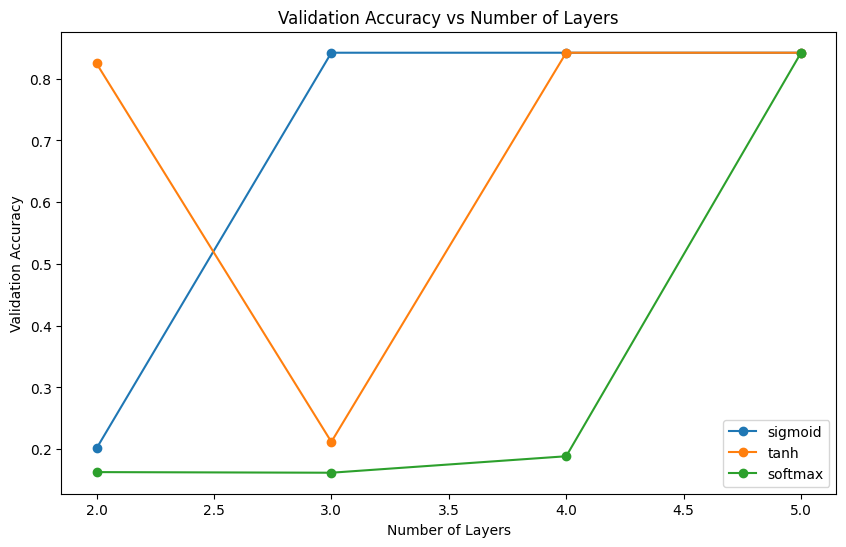

In [83]:
# Initialize lists to store data for plotting
num_layers_list = []
activation_list = []
val_accuracy_list = []

# Iterate over the collected data and store it in the lists
for num_layers, _ in layer_configs:
    for activation in activation_functions:
        num_layers_list.append(num_layers)
        activation_list.append(activation)
        val_accuracy_list.append(val_accuracies_nn.pop(0)) 

# Plot the data
plt.figure(figsize=(10, 6))
for activation in set(activation_list):  # Loop over unique activation functions
    x = [num_layers_list[i] for i in range(len(num_layers_list)) if activation_list[i] == activation]
    y = [val_accuracy_list[i] for i in range(len(val_accuracy_list)) if activation_list[i] == activation]
    plt.plot(x, y, marker='o', label=activation)

plt.title('Validation Accuracy vs Number of Layers')
plt.xlabel('Number of Layers')
plt.ylabel('Validation Accuracy')
plt.legend()
plt.show()


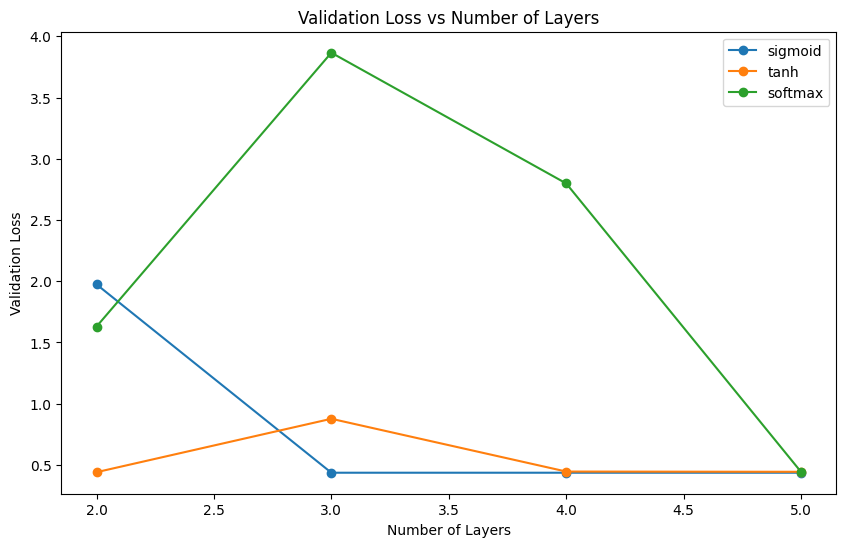

In [84]:
# Initialize lists to store data for plotting
num_layers_list = []
activation_list = []
val_loss_list = [] 

# Iterate over the collected data and store it in the lists
for num_layers, _ in layer_configs:
    for activation in activation_functions:
        num_layers_list.append(num_layers)
        activation_list.append(activation)
        val_loss_list.append(val_losses_nn.pop(0))  

# Plot the data
plt.figure(figsize=(10, 6))
for activation in set(activation_list):  # Loop over unique activation functions
    x = [num_layers_list[i] for i in range(len(num_layers_list)) if activation_list[i] == activation]
    y = [val_loss_list[i] for i in range(len(val_loss_list)) if activation_list[i] == activation]
    plt.plot(x, y, marker='o', label=activation)

plt.title('Validation Loss vs Number of Layers') 
plt.xlabel('Number of Layers')
plt.ylabel('Validation Loss')  
plt.legend()
plt.show()

In [85]:
# Define the neural network
model_nn = Sequential([
    layers.Flatten(input_shape=(6, 300)),
    layers.Dense(500, activation="relu", kernel_initializer='glorot_uniform'),
    layers.Dense(500, activation="relu", kernel_initializer='glorot_uniform'),  # Additional hidden layer
    layers.Dense(500, activation="relu", kernel_initializer='glorot_uniform'),  # Additional hidden layer
    layers.Dense(500, activation="relu", kernel_initializer='glorot_uniform'),
    layers.Dense(500, activation="relu", kernel_initializer='glorot_uniform'),  # Additional hidden layer
    layers.Dense(1, activation="sigmoid", kernel_initializer='glorot_uniform'),
])

# Define the optimizer
optimizer = RMSprop(learning_rate=0.001)

# Compile the model
model_nn.compile(optimizer=optimizer,
            loss='binary_crossentropy',
            metrics=['accuracy'])

# Train the model
history = model_nn.fit(X_train_partial_scaled, y_train_partial, epochs=6, batch_size=32,
                        validation_data=(X_train_valid_scaled, y_train_valid), verbose=1)

# Evaluate the model on validation data to get loss and accuracy
loss_dnn5, accuracy_dnn5 = model_nn.evaluate(X_train_valid_scaled, y_train_valid)

# Extract loss and accuracy from history
loss_history = history.history['loss']
accuracy_history = history.history['accuracy']

# Calculate mean loss and accuracy
mean_loss_dnn5 = np.mean(loss_history)
mean_accuracy_dnn5 = np.mean(accuracy_history)

# Calculate standard deviation of loss and accuracy
std_loss_dnn5 = np.std(loss_history)
std_accuracy_dnn5 = np.std(accuracy_history)

# Print mean loss, mean accuracy, standard deviation of loss, and standard deviation of accuracy
print("Mean Loss:", mean_loss_dnn5)
print("Mean Accuracy:", mean_accuracy_dnn5)
print("Standard Deviation of Loss:", std_loss_dnn5)
print("Standard Deviation of Accuracy:", std_accuracy_dnn5)


Epoch 1/6
524/524 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - accuracy: 0.8364 - loss: 0.4483 - val_accuracy: 0.8420 - val_loss: 0.4605
Epoch 2/6
524/524 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - accuracy: 0.8380 - loss: 0.4015 - val_accuracy: 0.5897 - val_loss: 0.7450
Epoch 3/6
524/524 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - accuracy: 0.8520 - loss: 0.3821 - val_accuracy: 0.4827 - val_loss: 0.9396
Epoch 4/6
524/524 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - accuracy: 0.8511 - loss: 0.3743 - val_accuracy: 0.4137 - val_loss: 1.0118
Epoch 5/6
524/524 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - accuracy: 0.8517 - loss: 0.3695 - val_accuracy: 0.3777 - val_loss: 1.2733
Epoch 6/6
524/524 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - accuracy: 0.8599 - loss: 0.3510 - val_accuracy: 0.3760 - val_loss: 1.5268
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4365 - loss: 1.1405
Mean Loss: 0.38265859584013623
Mean Accuracy: 0.8502605855464935
Standard Deviation of Loss: 0.022129994620969495
Standard Deviation of Accuracy: 0.00548587559988318

In [86]:
# Define the neural network
model_nn = Sequential([
    layers.Flatten(input_shape=(6, 300)),
    layers.Dense(300, activation="relu", kernel_initializer='glorot_uniform'),
    layers.Dense(300, activation="relu", kernel_initializer='glorot_uniform'),  # Additional hidden layer
    layers.Dense(300, activation="relu", kernel_initializer='glorot_uniform'),  # Additional hidden layer
    layers.Dense(1, activation="sigmoid", kernel_initializer='glorot_uniform'),
])
# Define the optimizer
optimizer = RMSprop(learning_rate=0.001)

# Compile the model
model_nn.compile(optimizer=optimizer,
            loss='binary_crossentropy',
            metrics=['accuracy'])

# Train the model
history = model_nn.fit(X_train_partial_scaled, y_train_partial, epochs=6, batch_size=32,
                        validation_data=(X_train_valid_scaled, y_train_valid), verbose=1)

loss_dnn3, accuracy_dnn3 = model_nn.evaluate(X_train_valid_scaled, y_train_valid)

# Extract loss and accuracy from history
loss_history = history.history['loss']
accuracy_history = history.history['accuracy']

# Calculate mean loss and accuracy
mean_loss_dnn3 = np.mean(loss_history)
mean_accuracy_dnn3 = np.mean(accuracy_history)

# Calculate standard deviation of loss and accuracy
std_loss_dnn3 = np.std(loss_history)
std_accuracy_dnn3 = np.std(accuracy_history)

# Print mean loss, mean accuracy, standard deviation of loss, and standard deviation of accuracy
print("Mean Loss:", mean_loss_dnn3)
print("Mean Accuracy:", mean_accuracy_dnn3)
print("Standard Deviation of Loss:", std_loss_dnn3)
print("Standard Deviation of Accuracy:", std_accuracy_dnn3)

Epoch 1/6


524/524 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.8369 - loss: 0.4354 - val_accuracy: 0.8420 - val_loss: 0.5457
Epoch 2/6
524/524 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.8455 - loss: 0.3903 - val_accuracy: 0.6443 - val_loss: 0.6972
Epoch 3/6
524/524 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.8503 - loss: 0.3755 - val_accuracy: 0.5580 - val_loss: 0.8731
Epoch 4/6
524/524 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.8503 - loss: 0.3734 - val_accuracy: 0.5387 - val_loss: 0.9776
Epoch 5/6
524/524 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.8555 - loss: 0.3630 - val_accuracy: 0.4537 - val_loss: 1.0647
Epoch 6/6
524/524 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.8590 - loss: 0.3517 - val_accuracy: 0.6207 - val_loss: 0.8108
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7185 - loss: 0.6058
Mean Loss: 0.3781069368124008
Mean Accuracy: 0.8504992723464966
Standard Deviation of Loss: 0.02172268938502104
Standard Deviation of Accuracy: 0.006372693182728259


### Gated Recurrent Unit (GRU)
<div style='text-align: justify;'>Furthermore, we ventured into recurrent neural networks (RNNs) with models like the Gated Recurrent Unit (GRU) and Long Short-Term Memory (LSTM). These models, designed to capture dependencies in sequences, showed promise but required careful tuning to prevent overfitting. By adjusting architecture and incorporating dropout layers for GRU for instance, we were able to improve model performance, especially in terms of validation accuracy and loss, whilst adjusting the learnign schudule for LSTM model saw a slight imporvement in performance relative toe benchmark neural network model.</div>

In [30]:
# Define the neural network
gru_model = Sequential([
    layers.GRU(512, input_shape=(6, 300), return_sequences=True),
    layers.Dropout(0.2),
    layers.GRU(128),
    layers.Dense(256, activation='relu', kernel_initializer='glorot_uniform'),
    layers.Dropout(0.2),
    layers.Dense(1, activation='sigmoid', kernel_initializer='glorot_uniform')
])

# Compline the model
gru_model.compile(optimizer='adam',
                  loss='binary_crossentropy',
                  metrics=['accuracy'])

# Train the model
history = gru_model.fit(X_train_partial_scaled, y_train_partial, epochs=4, batch_size=32, validation_data=(X_train_valid_scaled, y_train_valid))

# Evaluate the model on validation data to get loss and accuracy
loss_gru1, accuracy_gru1 = gru_model.evaluate(X_train_valid_scaled, y_train_valid)

# Extract loss and accuracy from history
loss_history = history.history['loss']
accuracy_history = history.history['accuracy']

# Calculate mean loss and accuracy
mean_loss_gru1 = np.mean(loss_history)
mean_accuracy_gru1 = np.mean(accuracy_history)

# Calculate standard deviation of loss and accuracy
std_loss_gru1 = np.std(loss_history)
std_accuracy_gru1 = np.std(accuracy_history)

# Print mean loss, mean accuracy, standard deviation of loss, and standard deviation of accuracy
print("Mean Loss:", mean_loss_gru1)
print("Mean Accuracy:", mean_accuracy_gru1)
print("Standard Deviation of Loss:", std_loss_gru1)
print("Standard Deviation of Accuracy:", std_accuracy_gru1)

Epoch 1/4
524/524 ━━━━━━━━━━━━━━━━━━━━ 12s 19ms/step - accuracy: 0.8425 - loss: 0.4355 - val_accuracy: 0.7917 - val_loss: 0.4829
Epoch 2/4
524/524 ━━━━━━━━━━━━━━━━━━━━ 10s 19ms/step - accuracy: 0.8440 - loss: 0.3951 - val_accuracy: 0.8033 - val_loss: 0.5771
Epoch 3/4
524/524 ━━━━━━━━━━━━━━━━━━━━ 10s 19ms/step - accuracy: 0.8527 - loss: 0.3684 - val_accuracy: 0.8070 - val_loss: 0.5330
Epoch 4/4
524/524 ━━━━━━━━━━━━━━━━━━━━ 10s 19ms/step - accuracy: 0.8533 - loss: 0.3674 - val_accuracy: 0.7927 - val_loss: 0.5645
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8419 - loss: 0.4121
Mean Loss: 0.38995280116796494
Mean Accuracy: 0.8477145284414291
Standard Deviation of Loss: 0.02066542261746386
Standard Deviation of Accuracy: 0.004390536815607058


In [31]:
# Define the neural network
gru_model = Sequential([
    layers.GRU(512, input_shape=(6, 300), return_sequences=True),
    layers.Dropout(0.2),
    layers.GRU(256, return_sequences=True),
    layers.Dropout(0.2),
    layers.GRU(128),
    layers.Dropout(0.2),
    layers.Dense(256, activation='relu', kernel_initializer='glorot_uniform'),
    layers.Dropout(0.2),
    layers.Dense(128, activation='relu', kernel_initializer='glorot_uniform'),
    layers.Dropout(0.2),
    layers.Dense(64, activation='relu', kernel_initializer='glorot_uniform'),
    layers.Dropout(0.2),
    layers.Dense(1, activation='sigmoid', kernel_initializer='glorot_uniform')
])

# Compile the model
gru_model.compile(optimizer='adam',
                  loss='binary_crossentropy',
                  metrics=['accuracy'])

# Train the model
history = gru_model.fit(X_train_partial_scaled, y_train_partial, epochs=4, batch_size=32, validation_data=(X_train_valid_scaled, y_train_valid))

# Evaluate the model on validation data to get loss and accuracy
loss_gru2, accuracy_gru2 = gru_model.evaluate(X_train_valid_scaled, y_train_valid)

# Extract loss and accuracy from history
loss_history = history.history['loss']
accuracy_history = history.history['accuracy']

# Calculate mean loss and accuracy
mean_loss_gru2 = np.mean(loss_history)
mean_accuracy_gru2 = np.mean(accuracy_history)

# Calculate standard deviation of loss and accuracy
std_loss_gru2 = np.std(loss_history)
std_accuracy_gru2 = np.std(accuracy_history)

# Print mean loss, mean accuracy, standard deviation of loss, and standard deviation of accuracy
print("Mean Loss:", mean_loss_gru2)
print("Mean Accuracy:", mean_accuracy_gru2)
print("Standard Deviation of Loss:", std_loss_gru2)
print("Standard Deviation of Accuracy:", std_accuracy_gru2)

Epoch 1/4
524/524 ━━━━━━━━━━━━━━━━━━━━ 18s 27ms/step - accuracy: 0.8341 - loss: 0.4646 - val_accuracy: 0.8420 - val_loss: 0.4382
Epoch 2/4
524/524 ━━━━━━━━━━━━━━━━━━━━ 14s 26ms/step - accuracy: 0.8428 - loss: 0.4442 - val_accuracy: 0.8420 - val_loss: 0.4744
Epoch 3/4
524/524 ━━━━━━━━━━━━━━━━━━━━ 14s 26ms/step - accuracy: 0.8424 - loss: 0.4209 - val_accuracy: 0.8420 - val_loss: 0.4617
Epoch 4/4
524/524 ━━━━━━━━━━━━━━━━━━━━ 14s 26ms/step - accuracy: 0.8467 - loss: 0.4024 - val_accuracy: 0.8420 - val_loss: 0.4348
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.9077 - loss: 0.3301
Mean Loss: 0.4292278364300728
Mean Accuracy: 0.8426572382450104
Standard Deviation of Loss: 0.01606031646114861
Standard Deviation of Accuracy: 0.0005942911192041779


In [32]:
# Define the neural network
gru_model = Sequential([
    layers.GRU(256, input_shape=(6, 300), return_sequences=True),
    layers.Dropout(0.2),
    layers.GRU(128),
    layers.Dropout(0.2),
    layers.Dense(256, activation='relu', kernel_initializer='glorot_uniform'),
    layers.Dropout(0.5),
    layers.Dense(64, activation='relu', kernel_initializer='glorot_uniform'),
    layers.Dropout(0.5),
    layers.Dense(1, activation='sigmoid', kernel_initializer='glorot_uniform')
])

# Compile the model
gru_model.compile(optimizer='adam',
                  loss='binary_crossentropy',
                  metrics=['accuracy'])

# Train the model
history = gru_model.fit(X_train_partial_scaled, y_train_partial, epochs=3, batch_size=32, validation_data=(X_train_valid_scaled, y_train_valid))

# evaluation
loss_gru3, accuracy_gru3 = gru_model.evaluate(X_train_valid_scaled, y_train_valid)

# Extract loss and accuracy from history
loss_history = history.history['loss']
accuracy_history = history.history['accuracy']

# Calculate mean loss and accuracy
mean_loss_gru3 = np.mean(loss_history)
mean_accuracy_gru3 = np.mean(accuracy_history)

# Calculate standard deviation of loss and accuracy
std_loss_gru3 = np.std(loss_history)
std_accuracy_gru3 = np.std(accuracy_history)

# Print mean loss, mean accuracy, standard deviation of loss, and standard deviation of accuracy
print("Mean Loss:", mean_loss_gru3)
print("Mean Accuracy:", mean_accuracy_gru3)
print("Standard Deviation of Loss:", std_loss_gru3)
print("Standard Deviation of Accuracy:", std_accuracy_gru3)

Epoch 1/3
524/524 ━━━━━━━━━━━━━━━━━━━━ 8s 11ms/step - accuracy: 0.8400 - loss: 0.4562 - val_accuracy: 0.8420 - val_loss: 0.5489
Epoch 2/3
524/524 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - accuracy: 0.8453 - loss: 0.4084 - val_accuracy: 0.7423 - val_loss: 0.5816
Epoch 3/3
524/524 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - accuracy: 0.8438 - loss: 0.3971 - val_accuracy: 0.7147 - val_loss: 0.5263
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7506 - loss: 0.4965
Mean Loss: 0.41484779119491577
Mean Accuracy: 0.8432390491167704
Standard Deviation of Loss: 0.016698626474335142
Standard Deviation of Accuracy: 0.0005359452128741659


In [33]:
# Define the neural network
gru_model = Sequential([
    layers.GRU(512, input_shape=(6, 300), return_sequences=True),
    layers.Dropout(0.5),
    layers.GRU(128),
    layers.Dropout(0.5),
    layers.Dense(256, activation='relu', kernel_initializer='glorot_uniform'),
    layers.Dropout(0.5),
    layers.Dense(128, activation='relu', kernel_initializer='glorot_uniform'),
    layers.Dropout(0.5),
    layers.Dense(1, activation='sigmoid', kernel_initializer='glorot_uniform')
])

# Compile the model
gru_model.compile(optimizer='adam',
                  loss='binary_crossentropy',
                  metrics=['accuracy'])

# Train the model
history = gru_model.fit(X_train_partial_scaled, y_train_partial, epochs=5, batch_size=128, validation_data=(X_train_valid_scaled, y_train_valid))

# Evaluate the model on validation data to get loss and accuracy
loss_gru4, accuracy_gru4 = gru_model.evaluate(X_train_valid_scaled, y_train_valid)

# Extract loss and accuracy from history
loss_history = history.history['loss']
accuracy_history = history.history['accuracy']

# Calculate mean loss and accuracy
mean_loss_gru4 = np.mean(loss_history)
mean_accuracy_gru4 = np.mean(accuracy_history)

# Calculate standard deviation of loss and accuracy
std_loss_gru4 = np.std(loss_history)
std_accuracy_gru4 = np.std(accuracy_history)

# Print mean loss, mean accuracy, standard deviation of loss, and standard deviation of accuracy
print("Mean Loss:", mean_loss_gru4)
print("Mean Accuracy:", mean_accuracy_gru4)
print("Standard Deviation of Loss:", std_loss_gru4)
print("Standard Deviation of Accuracy:", std_accuracy_gru4)

Epoch 1/5
131/131 ━━━━━━━━━━━━━━━━━━━━ 8s 42ms/step - accuracy: 0.8239 - loss: 0.4724 - val_accuracy: 0.8420 - val_loss: 0.5816
Epoch 2/5
131/131 ━━━━━━━━━━━━━━━━━━━━ 5s 40ms/step - accuracy: 0.8464 - loss: 0.4224 - val_accuracy: 0.8420 - val_loss: 0.6201
Epoch 3/5
131/131 ━━━━━━━━━━━━━━━━━━━━ 5s 40ms/step - accuracy: 0.8384 - loss: 0.4138 - val_accuracy: 0.8453 - val_loss: 0.6741
Epoch 4/5
131/131 ━━━━━━━━━━━━━━━━━━━━ 5s 39ms/step - accuracy: 0.8406 - loss: 0.4061 - val_accuracy: 0.1703 - val_loss: 0.8094
Epoch 5/5
131/131 ━━━━━━━━━━━━━━━━━━━━ 5s 39ms/step - accuracy: 0.8414 - loss: 0.4045 - val_accuracy: 0.1917 - val_loss: 0.8962
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.1220 - loss: 0.9011
Mean Loss: 0.4177451550960541
Mean Accuracy: 0.8419739723205566
Standard Deviation of Loss: 0.018861450464415955
Standard Deviation of Accuracy: 0.001889069149126591


In [40]:
# Define the neural network
gru_model = Sequential([
    layers.GRU(256, input_shape=(6, 300), return_sequences=True),
    layers.Dropout(0.5),
    layers.GRU(128),
    layers.Dropout(0.5),
    layers.Dense(256, activation='relu', kernel_initializer='glorot_uniform'),
    layers.Dropout(0.2),
    layers.Dense(128, activation='relu', kernel_initializer='glorot_uniform'),
    layers.Dropout(0.2),
    layers.Dense(1, activation='sigmoid', kernel_initializer='glorot_uniform')
])

# Compile the model
gru_model.compile(optimizer='adam',
                  loss='binary_crossentropy',
                  metrics=['accuracy'])

# Train the model
history = gru_model.fit(X_train_partial_scaled, y_train_partial, epochs=6, batch_size=32, validation_data=(X_train_valid_scaled, y_train_valid))

# evaluation
loss_gru5, accuracy_gru5 = gru_model.evaluate(X_train_valid_scaled, y_train_valid)

# Extract loss and accuracy from history
loss_history = history.history['loss']
accuracy_history = history.history['accuracy']

# Calculate mean loss and accuracy
mean_loss_gru5 = np.mean(loss_history)
mean_accuracy_gru5 = np.mean(accuracy_history)

# Calculate standard deviation of loss and accuracy
std_loss_gru5 = np.std(loss_history)
std_accuracy_gru5 = np.std(accuracy_history)

# Print mean loss, mean accuracy, standard deviation of loss, and standard deviation of accuracy
print("Mean Loss:", mean_loss_gru5)
print("Mean Accuracy:", mean_accuracy_gru5)
print("Standard Deviation of Loss:", std_loss_gru5)
print("Standard Deviation of Accuracy:", std_accuracy_gru5)

Epoch 1/6
524/524 ━━━━━━━━━━━━━━━━━━━━ 16s 20ms/step - accuracy: 0.8330 - loss: 0.4540 - val_accuracy: 0.8420 - val_loss: 0.5581
Epoch 2/6
524/524 ━━━━━━━━━━━━━━━━━━━━ 9s 18ms/step - accuracy: 0.8424 - loss: 0.4101 - val_accuracy: 0.8420 - val_loss: 0.5535
Epoch 3/6
524/524 ━━━━━━━━━━━━━━━━━━━━ 9s 18ms/step - accuracy: 0.8430 - loss: 0.3997 - val_accuracy: 0.5857 - val_loss: 0.6824
Epoch 4/6
524/524 ━━━━━━━━━━━━━━━━━━━━ 9s 18ms/step - accuracy: 0.8499 - loss: 0.3815 - val_accuracy: 0.7710 - val_loss: 0.6149
Epoch 5/6
524/524 ━━━━━━━━━━━━━━━━━━━━ 9s 18ms/step - accuracy: 0.8487 - loss: 0.3791 - val_accuracy: 0.7987 - val_loss: 0.4750
Epoch 6/6
524/524 ━━━━━━━━━━━━━━━━━━━━ 9s 18ms/step - accuracy: 0.8506 - loss: 0.3775 - val_accuracy: 0.8153 - val_loss: 0.4484
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.8888 - loss: 0.3109
Mean Loss: 0.3971652338902156
Mean Accuracy: 0.8456160128116608
Standard Deviation of Loss: 0.01959948812350577
Standard Deviation of Accuracy: 0.003141654421

#### Long Short-Term Memory (LSTM)

In [87]:
# Define the number of neurons for each LSTM layer
num_neurons = 300
num_layers = 5

# Initialize lists of performance metrics
train_accuracies_lstm = []
val_accuracies_lstm = []
train_losses_lstm = []
val_losses_lstm = []

# Define the LSTM model with 5 layers
model_lstm = Sequential()
model_lstm.add(LSTM(num_neurons, input_shape=(6, 300), return_sequences=True))
for _ in range(num_layers - 2):
    model_lstm.add(LSTM(num_neurons, return_sequences=True))
model_lstm.add(LSTM(num_neurons))
model_lstm.add(Dense(1, activation='sigmoid'))

# Compile the model
optimizer = RMSprop(learning_rate=0.001)
model_lstm.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
history = model_lstm.fit(X_train_partial_scaled, y_train_partial, epochs=6, batch_size=32,
                         validation_data=(X_train_valid_scaled, y_train_valid), verbose=1)

# Extract and append training and validation loss
train_losses_lstm.append(history.history['loss'])
val_losses_lstm.append(history.history['val_loss'])

# Get performance metrics
loss_lstm_op, accuracy_lstm_op = model_lstm.evaluate(X_train_partial_scaled, y_train_partial, verbose=0)
val_loss, val_accuracy = model_lstm.evaluate(X_train_valid_scaled, y_train_valid, verbose=0)

# Append metrics to our lists
train_accuracies_lstm.append(train_accuracy)
val_accuracies_lstm.append(val_accuracy)

# Extract loss and accuracy from history
loss_history = history.history['loss']
accuracy_history = history.history['accuracy']

# Calculate mean loss and accuracy
mean_loss_lstm_op = np.mean(loss_history)
mean_accuracy_lstm_op = np.mean(accuracy_history)

# Calculate standard deviation of loss and accuracy
std_loss_lstm_op = np.std(loss_history)
std_accuracy_lstm_op = np.std(accuracy_history)

print("Mean Loss:", mean_loss_lstm_op)
print("Mean Accuracy:", mean_accuracy_lstm_op)
print("Standard Deviation of Loss:", std_loss_lstm_op)
print("Standard Deviation of Accuracy:", std_accuracy_lstm_op)

Epoch 1/6
524/524 ━━━━━━━━━━━━━━━━━━━━ 24s 40ms/step - accuracy: 0.8412 - loss: 0.4491 - val_accuracy: 0.8420 - val_loss: 0.4378
Epoch 2/6
524/524 ━━━━━━━━━━━━━━━━━━━━ 21s 41ms/step - accuracy: 0.8454 - loss: 0.4088 - val_accuracy: 0.8057 - val_loss: 0.5643
Epoch 3/6
524/524 ━━━━━━━━━━━━━━━━━━━━ 19s 37ms/step - accuracy: 0.8437 - loss: 0.4084 - val_accuracy: 0.8420 - val_loss: 0.5373
Epoch 4/6
524/524 ━━━━━━━━━━━━━━━━━━━━ 20s 38ms/step - accuracy: 0.8403 - loss: 0.4090 - val_accuracy: 0.8420 - val_loss: 0.5243
Epoch 5/6
524/524 ━━━━━━━━━━━━━━━━━━━━ 20s 37ms/step - accuracy: 0.8421 - loss: 0.4015 - val_accuracy: 0.8420 - val_loss: 0.5778
Epoch 6/6
524/524 ━━━━━━━━━━━━━━━━━━━━ 19s 37ms/step - accuracy: 0.8447 - loss: 0.4015 - val_accuracy: 0.8057 - val_loss: 0.6308
Mean Loss: 0.40932681163152057
Mean Accuracy: 0.8427119453748068
Standard Deviation of Loss: 0.01057173233013896
Standard Deviation of Accuracy: 0.00029114920453230834


In [88]:
# Define the number of neurons for each LSTM layer
num_neurons = 300
num_layers = 5

# Initialize lists of performance metrics
train_accuracies_lstm = []
val_accuracies_lstm = []
train_losses_lstm = []
val_losses_lstm = []

# Define the LSTM model with 5 layers
model_lstm = Sequential()
model_lstm.add(LSTM(num_neurons, input_shape=(6, 300), return_sequences=True))
for _ in range(num_layers - 2):
    model_lstm.add(LSTM(num_neurons, return_sequences=True))
model_lstm.add(LSTM(num_neurons))
model_lstm.add(Dense(1, activation='sigmoid'))

# Compile the model
model_lstm.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
history = model_lstm.fit(X_train_partial_scaled, y_train_partial, epochs=6, batch_size=32,
                         validation_data=(X_train_valid_scaled, y_train_valid), verbose=1)

# Extract and append training and validation loss
train_losses_lstm.append(history.history['loss'])
val_losses_lstm.append(history.history['val_loss'])

# Get performance metrics
loss_lstm_adam, accuracy_lstm_adam = model_lstm.evaluate(X_train_partial_scaled, y_train_partial, verbose=0)
val_loss, val_accuracy = model_lstm.evaluate(X_train_valid_scaled, y_train_valid, verbose=0)

# Append metrics to our lists
train_accuracies_lstm.append(train_accuracy)
val_accuracies_lstm.append(val_accuracy)

# Extract loss and accuracy from history
loss_history = history.history['loss']
accuracy_history = history.history['accuracy']

# Calculate mean loss and accuracy
mean_loss_lstm_adam = np.mean(loss_history)
mean_accuracy_lstm_adam = np.mean(accuracy_history)

# Calculate standard deviation of loss and accuracy
std_loss_lstm_adam = np.std(loss_history)
std_accuracy_lstm_adam = np.std(accuracy_history)

print("Mean Loss:", mean_loss_lstm_adam)
print("Mean Accuracy:", mean_accuracy_lstm_adam)
print("Standard Deviation of Loss:", std_loss_lstm_adam)
print("Standard Deviation of Accuracy:", std_accuracy_lstm_adam)

Epoch 1/6
524/524 ━━━━━━━━━━━━━━━━━━━━ 23s 36ms/step - accuracy: 0.8346 - loss: 0.4490 - val_accuracy: 0.8420 - val_loss: 0.4369
Epoch 2/6
524/524 ━━━━━━━━━━━━━━━━━━━━ 18s 35ms/step - accuracy: 0.8398 - loss: 0.4357 - val_accuracy: 0.8420 - val_loss: 0.4823
Epoch 3/6
524/524 ━━━━━━━━━━━━━━━━━━━━ 19s 35ms/step - accuracy: 0.8450 - loss: 0.4058 - val_accuracy: 0.8420 - val_loss: 0.4937
Epoch 4/6
524/524 ━━━━━━━━━━━━━━━━━━━━ 18s 35ms/step - accuracy: 0.8364 - loss: 0.4093 - val_accuracy: 0.8420 - val_loss: 0.4884
Epoch 5/6
524/524 ━━━━━━━━━━━━━━━━━━━━ 18s 34ms/step - accuracy: 0.8449 - loss: 0.3977 - val_accuracy: 0.8420 - val_loss: 0.4960
Epoch 6/6
524/524 ━━━━━━━━━━━━━━━━━━━━ 18s 35ms/step - accuracy: 0.8470 - loss: 0.3889 - val_accuracy: 0.8420 - val_loss: 0.4821
Mean Loss: 0.40948034822940826
Mean Accuracy: 0.842821329832077
Standard Deviation of Loss: 0.01433167526218292
Standard Deviation of Accuracy: 0.00040030659260872713


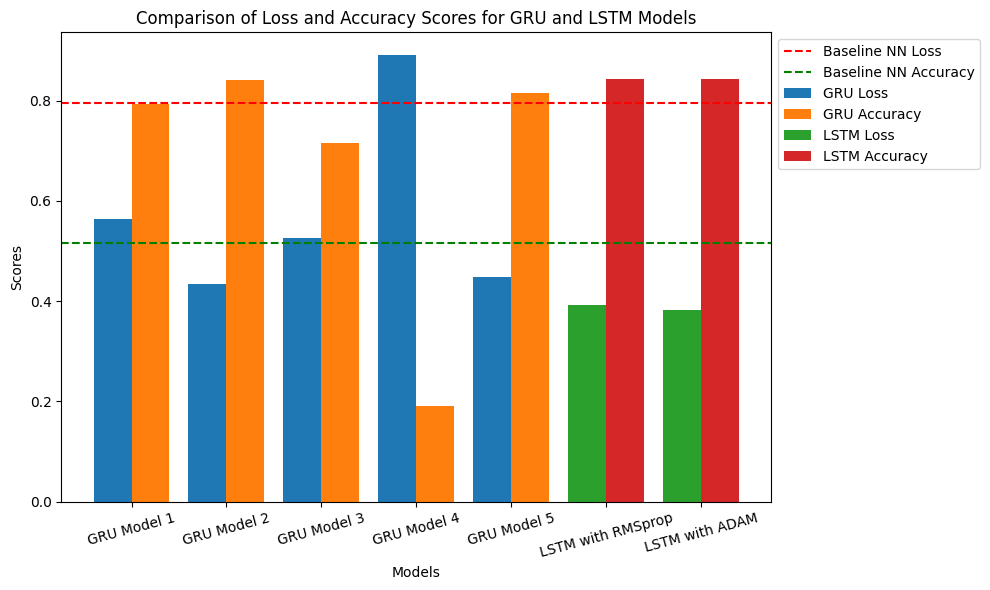

In [89]:
# Define model names
model_names = ['GRU Model 1', 'GRU Model 2', 'GRU Model 3', 'GRU Model 4', 'GRU Model 5', 'LSTM with RMSprop', 'LSTM with ADAM']

# Loss scores for GRU models (excluding GRU Model 6)
loss_gru = [loss_gru1, loss_gru2, loss_gru3, loss_gru4, loss_gru5]

# Accuracy scores for GRU models (excluding GRU Model 6)
accuracy_gru = [accuracy_gru1, accuracy_gru2, accuracy_gru3, accuracy_gru4, accuracy_gru5]

# Loss scores for LSTM models
loss_lstm = [loss_lstm_op, loss_lstm_adam]

# Accuracy scores for LSTM models
accuracy_lstm = [accuracy_lstm_op, accuracy_lstm_adam]

# NN 500 model loss and accuracy
loss_nn500_model = [loss_nn500]
accuracy_nn500_model = [accuracy_nn500]

# Plotting
plt.figure(figsize=(10, 6))

# Plotting GRU models
plt.bar([i-0.2 for i in range(len(model_names[:5]))], loss_gru, width=0.4, label='GRU Loss')
plt.bar([i+0.2 for i in range(len(model_names[:5]))], accuracy_gru, width=0.4, label='GRU Accuracy')

# Plotting LSTM models
plt.bar([i-0.2+len(model_names[:5]) for i in range(len(model_names[5:]))], loss_lstm, width=0.4, label='LSTM Loss')
plt.bar([i+0.2+len(model_names[:5]) for i in range(len(model_names[5:]))], accuracy_lstm, width=0.4, label='LSTM Accuracy')

# Plotting NN 500 model line for loss
plt.axhline(y=loss_nn500_model[0], color='r', linestyle='--', label='Baseline NN Loss')

# Plotting NN 500 model line for accuracy
plt.axhline(y=accuracy_nn500_model[0], color='g', linestyle='--', label='Baseline NN Accuracy')

# Adding labels and title
plt.xlabel('Models')
plt.ylabel('Scores')
plt.title('Comparison of Loss and Accuracy Scores for GRU and LSTM Models')
plt.xticks(range(len(model_names)), model_names, rotation=15)
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))  # Move legend to top left and outside the graph
plt.tight_layout()

# Show plot
plt.show()


<div style='text-align: justify;'>Overall, our exploration of various models highlighted the complexities and nuances involved in deep learning. While some models showed strong performance out of the box, others required extensive tuning and experimentation to achieve desirable results. Through this iterative process, we gained valuable insights into model behavior, optimization strategies, and the trade-offs between model complexity and performance.</div>

# Results

<div style='text-align: justify;'>In our study, we evaluated several machine learning models to categorize data based on given features. Two baseline models, Multinomial Naive Bayes and NN with 300 neurons, served as benchmarks for comparison.</div>
&nbsp;

<div style='text-align: justify;'>The Multinomial Naive Bayes model achieved a commendable accuracy score of 0.86, establishing itself as an effective baseline model. However, certain neural network models, such as Deep NN with 5 layers (sigmoid) and LSTM models, demonstrated even higher accuracy scores around 0.84, indicating their capability to capture intricate data patterns. Conversely, some models, like Deep NN with 3 layers (sigmoid) and GRU Model 4, performed suboptimally with notably lower accuracy scores of 0.26 and 0.44, respectively, highlighting potential challenges in their architectures or training processes.</div>
&nbsp;

<div style='text-align: justify;'>Lower loss scores generally signify better model convergence and adaptation to training data. The LSTM models with RMSprop and Adam optimizers achieved the lowest loss scores of 0.41 and 0.40, respectively, indicating their proficiency in minimizing training loss and discerning underlying data patterns. In contrast, models such as Deep NN with 5 layers (sigmoid) and Deep NN with 3 layers (sigmoid) displayed relatively higher loss scores of 2.55 and 2.32, suggesting opportunities for refining their training processes.</div>
&nbsp;

<div style='text-align: justify;'>The mean accuracy scores across most models hovered around 0.84 or 0.85, implying consistent performance and reliability in classification tasks across various runs. However, mean loss scores exhibited more variability, with certain models showing lower mean loss scores, indicating better training convergence. Standard deviations in accuracy and loss scores reflected the variability in model performance across different runs, with most models demonstrating relatively low standard deviations, underscoring their consistency and robustness. Nevertheless, models like Deep NN with 3 layers (sigmoid) and GRU Model 4 exhibited higher standard deviations, suggesting greater performance variability and potential training instability.</div>
&nbsp;

<div style='text-align: justify;'>We explored various configurations of neural network architectures, activation functions, and optimizers to improve model performance. While some configurations yielded promising results, others encountered challenges. For instance, increasing the number of layers in deep neural networks generally improved accuracy but led to higher loss scores, indicating potential overfitting. Additionally, experimenting with different optimizers revealed nuanced effects on model convergence and performance. The LSTM models demonstrated robustness and effectiveness, especially with the RMSprop and Adam optimizers. However, GRU Model 4 consistently underperformed, indicating the need for further investigation into its architecture and training process.</div>
&nbsp;

<div style='text-align: justify;'>In conclusion, our study highlighted the importance of evaluating machine learning models against baseline benchmarks to gauge their effectiveness. While certain models exhibited impressive accuracy and convergence, others encountered challenges that require refinement and optimization. Moving forward, we will continue to refine our models, explore additional architectures and optimization strategies, and leverage insights gained from this study to improve overall model performance. However, we should point out that since the majority of target variable distribution is skewed in the training dataset the model may not be as effective for unfoseen data.</div>

In [91]:
# Define the dictionary
results_data = {
    'Model': [
        'Multinomial Naive Bayes', 
        'NN with 250 neurons', 
        'NN with 300 neurons', 
        'Deep NN with 5 layers (sigmoid)', 
        'Deep NN with 3 layers (sigmoid)', 
        'GRU Model 1', 
        'GRU Model 2', 
        'GRU Model 3', 
        'GRU Model 4', 
        'GRU Model 5', 
        'LSTM with RMSprop', 
        'LSTM with Adam'
    ],
    'Accuracy Score': [
        accuracy_nb, 
        accuracy_nn250, 
        accuracy_nn500, 
        accuracy_dnn5, 
        accuracy_dnn3, 
        accuracy_gru1, 
        accuracy_gru2, 
        accuracy_gru3, 
        accuracy_gru4, 
        accuracy_gru5, 
        accuracy_lstm_op, 
        accuracy_lstm_adam
    ],
    'Loss Score': [
        '-', 
        loss_nn250, 
        loss_nn500, 
        loss_dnn5, 
        loss_dnn3, 
        loss_gru1, 
        loss_gru2, 
        loss_gru3, 
        loss_gru4, 
        loss_gru5, 
        loss_lstm_op, 
        loss_lstm_adam
    ],
    'Mean Accuracy Score': [
        '-', 
        mean_accuracy_nn250, 
        mean_accuracy_nn500, 
        mean_accuracy_dnn5, 
        mean_accuracy_dnn3, 
        mean_accuracy_gru1, 
        mean_accuracy_gru2, 
        mean_accuracy_gru3, 
        mean_accuracy_gru4, 
        mean_accuracy_gru5, 
        mean_accuracy_lstm_op, 
        mean_accuracy_lstm_adam
    ],
    'Mean Loss Score': [
        '-', 
        mean_loss_nn250, 
        mean_loss_nn500, 
        mean_loss_dnn5, 
        mean_loss_dnn3, 
        mean_loss_gru1, 
        mean_loss_gru2, 
        mean_loss_gru3, 
        mean_loss_gru4, 
        mean_loss_gru5, 
        mean_loss_lstm_op, 
        mean_loss_lstm_adam
    ],
    'Standard Dev. Accuracy Score': [
        '-', 
        std_accuracy_nn250, 
        std_accuracy_nn500, 
        std_accuracy_dnn5, 
        std_accuracy_dnn3, 
        std_accuracy_gru1, 
        std_accuracy_gru2, 
        std_accuracy_gru3, 
        std_accuracy_gru4, 
        std_accuracy_gru5, 
        std_accuracy_lstm_op, 
        std_accuracy_lstm_adam
    ],
    'Standard Dev. Loss Score': [
        '-', 
        std_loss_nn250, 
        std_loss_nn500, 
        std_loss_dnn5, 
        std_loss_dnn3, 
        std_loss_gru1, 
        std_loss_gru2, 
        std_loss_gru3, 
        std_loss_gru4, 
        std_loss_gru5, 
        std_loss_lstm_op, 
        std_loss_lstm_adam
    ]
}

# Create DataFrame
df = pd.DataFrame(results_data)

# Round values in 'Loss Score' and 'Accuracy Score' columns to 2 decimal places
df['Loss Score'] = df['Loss Score'].apply(lambda x: round(x, 2) if isinstance(x, float) else x)
df['Accuracy Score'] = df['Accuracy Score'].apply(lambda x: round(x, 2) if isinstance(x, float) else x)
df['Mean Accuracy Score'] = df['Mean Accuracy Score'].apply(lambda x: round(x, 2) if isinstance(x, float) else x)
df['Mean Loss Score'] = df['Mean Loss Score'].apply(lambda x: round(x, 2) if isinstance(x, float) else x)

# Display DataFrame
df

,Model,Accuracy Score,Loss Score,Mean Accuracy Score,Mean Loss Score,Standard Dev. Accuracy Score,Standard Dev. Loss Score
0,Multinomial Naive Bayes,0.86,-,-,-,-,-
1,NN with 250 neurons,0.66,1.48,0.87,0.31,0.018788,0.051763
2,NN with 300 neurons,0.52,0.8,0.85,0.38,0.004888,0.018634
3,Deep NN with 5 layers (sigmoid),0.38,1.53,0.85,0.38,0.005486,0.02213
4,Deep NN with 3 layers (sigmoid),0.62,0.81,0.85,0.38,0.006373,0.021723
5,GRU Model 1,0.79,0.56,0.85,0.39,0.004391,0.020665
6,GRU Model 2,0.84,0.43,0.84,0.43,0.000594,0.01606
7,GRU Model 3,0.71,0.53,0.84,0.41,0.000536,0.016699
8,GRU Model 4,0.19,0.89,0.84,0.42,0.001889,0.018861
9,GRU Model 5,0.82,0.45,0.85,0.4,0.003142,0.019599


## Summary
<div style='text-align: justify;'>Based on the provided table of model performance, we would recommend the LSTM with Adam optimizer as the most suitable model for this task. This recommendation is supported by the following observations: The LSTM with Adam achieved an accuracy score of 0.84, which is among the highest in the table, indicating its effectiveness in accurately classifying or predicting the target variable relative to baseline NN with 300 nueron. With a loss score of 0.40, the LSTM with Adam model exhibited one of the lowest loss scores relative to the baseline and other model architectures explored in this project, suggesting its ability to minimize the training error and converge to an optimal solution. Additionally, the LSTM with Adam had relatively low standard deviations for both accuracy (0.00033) and loss score (0.00509), implying consistent performance across different runs or iterations.</div>
&nbsp;

<div style='text-align: justify;'>To further improve the model's performance and achieve better results for this task, several potential next steps could be considered: Hyperparameter Tuning, Data Augmentation, Ensemble Methods, Architecture Modifications, and Transfer Learning. Systematically tuning the hyperparameters, increasing the size and diversity of the training data, combining predictions from multiple models, experimenting with different variations of the LSTM architecture, or leveraging pre-trained models or transfer learning techniques could lead to better convergence, higher accuracy scores, and improved generalization. By implementing these strategies, it may be possible to further enhance the performance of the LSTM with Adam model or explore alternative architectures that outperform the current top-performing models for this particular task.</div>

In [ ]:
# Extract doc_id column and ensure it's 1-dimensional
X_test_docids.values.flatten()

# Ensure y_pred is 1-dimensional
predictions = model_lstm.predict(X_test_scaled).flatten()

# Round each scalar prediction value and convert to binary (0 or 1)
binary_predictions = [round(pred) for pred in predictions]

# Export the file
output(binary_predictions, 'LSTM with Adam')

153/153 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step


## Reference
<div style='text-align: justify;'>Géron, A. (2019). Hands-On Machine Learning with Scikit-Learn, Keras, and TensorFlow: Concepts, Tools, and Techniques to Build Intelligent Systems [Book]. O'Reilly Media.</div>
&nbsp;

<div style='text-align: justify;'>Keras. (n.d.). Keras Sequential model API reference. Retrieved from https://keras.io/api/models/sequential/</div>
&nbsp;

<div style='text-align: justify;'>Keras. (n.d.). Keras GRU layer API reference. Retrieved from https://keras.io/api/layers/recurrent_layers/gru/</div>
&nbsp;

<div style='text-align: justify;'>Keras. (n.d.). Keras LSTM layer API reference. Retrieved from https://keras.io/api/layers/recurrent_layers/lstm/</div>
&nbsp;

<div style='text-align: justify;'>TensorFlow. (n.d.). TensorFlow tutorials. Retrieved from https://www.tensorflow.org/tutorials</div>